In [ ]:
# Sentiment Classification Using RNNs

* Given the IMDB Movie Review Dataset, create an RNN model that predicts whether the given review is negative or positive.
* You need to create your Dataset, Dataloader and Model. Keep your code modular and avoid hardcoding any parameter. This will allow you to experiment more easily.
* Plot graphs for loss and accuracy for each epoch of a training loop. Try using wandb for logging training and validation losses, accuracies.
* Use tqdm to keep track of the status of the training loop for an epoch

### 1. RNN Model
#### 1.1 Build a Dataset from the IMDB Movie Review Dataset by taking reviews with word count between 100 and 500. Perform text processing on the movie reviews and create a word to index mapping for representing any review as a list of numbers.
#### 1.2 Create Dataloaders for the train, test and validation datasets with appropriate batch sizes.
#### 1.3 Create the Model class for the RNN Model. Create functions for running model training and testing.

In [ ]:
!ping google.com


In [1]:
!pip install datasets torchmetrics

In [2]:
!pip install datasets
!pip install nltk
!pip install torch
!pip install tqdm


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import Accuracy
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import re
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import RegexpTokenizer
import re
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
SEED = 1234

# set seed for all possible random functions to ensure reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic=True

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
# load the IMDB review dataset. You can take the dataset from Huggingface
imdb_dataset = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
# Split the train set into train and validation in 80-20 split. Use the labels
# to ensure that the ratio of the samples from each label is maintained


def split_train_val(dataset, test_size=0.2, random_state=SEED):
    reviews = dataset['train']['text']
    labels = dataset['train']['label']

    train_reviews, val_reviews, train_labels, val_labels = train_test_split(
        reviews, labels, test_size=test_size, random_state=random_state, stratify=labels
)

    return train_reviews, val_reviews, train_labels, val_labels

train_reviews, val_reviews, train_labels, val_labels = split_train_val(imdb_dataset)


In [8]:
'''
def clean(text, tokenizer):
  # Perform text preprocessing:
  # 1. Removing numbers OR replace them with "num" token
  # 2. Convert all characters to lowercase.
  # 3. Tokenize the sentence into words
  # You can use RegexpTokenizer from NLTK.

  # You will experiment with stemming/lemmatization down the line
  # so you can skip that for now

  return text
'''
#################################### without stemming##############################3
def clean(text, tokenizer):
    text = re.sub(r'\d+', 'num', text)
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    return tokens


tokenizer = RegexpTokenizer(r'\w+')
cleaned_text = clean("This IS 1 example sentence", tokenizer)
print(cleaned_text)


#####################################with stemming##################################


lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean2(text, tokenizer):
    text = re.sub(r'\d+', 'num', text)
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

['this', 'is', 'num', 'example', 'sentence']


In [9]:
clean2("This IS 1 example sentence. I am a good boy for 9 days", RegexpTokenizer(r'\w+'))

['thi',
 'is',
 'num',
 'exampl',
 'sentenc',
 'i',
 'am',
 'a',
 'good',
 'boy',
 'for',
 'num',
 'day']

In [10]:
# create a word to index dictionary so that each word in the training set
# has a number associated with it. This allows to represent each sentence
# as a series of numbers. Start the index with 1 instead of 0. The number
# 0 will be used to denote padding, so that each sentence can have the
# same length.
# Keep track of the index since it will be used for representing new words
# that were not part of the training vocabulary.
# Also, make sure to not create dictionary on sentences with word count
# not within the range
'''
def get_word2idx(corpus):
  idx = 1
  for sentence in tqdm(corpus, total=len(corpus), desc="Creating word2idx"):
    # process sentence
    sentence = clean(sentence, tokenizer)

    # drop sentences greater than maxlen or less than minlen

    # for each word in sentence, check for entry in word2idx

  return idx, word2idx
'''


def create_word2idx(reviews, min_words=100, max_words=500):
    word2idx = {}
    idx = 1  
    tokenizer = RegexpTokenizer(r'\w+')

    for review in tqdm(reviews, desc="Processing reviews for word2idx"):
        tokens = clean(review, tokenizer)
        if min_words <= len(tokens) <= max_words:
            for token in tokens:
                if token not in word2idx:
                    word2idx[token] = idx
                    idx += 1

    return word2idx


word2idx = create_word2idx(train_reviews)
print(f"Vocabulary size: {len(word2idx)}")
print(word2idx)

Processing reviews for word2idx: 100%|██████████| 20000/20000 [00:03<00:00, 6234.22it/s]

Vocabulary size: 58064
{'this': 1, 'movie': 2, 'was': 3, 'so': 4, 'poorly': 5, 'written': 6, 'and': 7, 'directed': 8, 'i': 9, 'fell': 10, 'asleep': 11, 'num': 12, 'minutes': 13, 'through': 14, 'the': 15, 'jokes': 16, 'in': 17, 'are': 18, 'corny': 19, 'even': 20, 'though': 21, 'plot': 22, 'is': 23, 'interesting': 24, 'at': 25, 'some': 26, 'angles': 27, 'it': 28, 'too': 29, 'far': 30, 'fetched': 31, 'points': 32, 'ridiculous': 33, 'if': 34, 'you': 35, 'or': 36, 'older': 37, 'will': 38, 'overlook': 39, 'writing': 40, 'be': 41, 'disappointed': 42, 'but': 43, 'younger': 44, 'a': 45, 'film': 46, 'that': 47, 'capture': 48, 'your': 49, 'attention': 50, 'amazed': 51, 'with': 52, 'all': 53, 'stunts': 54, 'which': 55, 'might': 56, 'add': 57, 'done': 58, 'wish': 59, 'were': 60, 'warrior': 61, 'to': 62, 'casting': 63, 'wasn': 64, 't': 65, 'very': 66, 'good': 67, 'music': 68, 'disappointing': 69, 'because': 70, 'like': 71, 'they': 72, 'trying': 73, 'build': 74, 'up': 75, 'tension': 76, 'didn': 77, '

In [11]:
# Build a Dataset object to store each sentence as a tensor of numbers
# along with the label. Make sure to add padding so that the tensor
# for each sentence is of the same length. This will allow us to train
# the model in batches.
'''
class IMDBDataset(Dataset):
  def __init__(self, dataset, split : str, minlen : int = 100, maxlen : int = 500):
    self.count = 0 # total sentences you finally pick

    # count total number of lines
    len = len(dataset[split])

    input_data = []
    target_data = []

    for idx, sentence in tqdm(enumerate(corpus), total=len, desc=f"Transforming input text [{split}]"):
      # process sentence

      # drop sentences greater than maxlen or less than minlen

      # replace words with their index


      self.count += 1

    # pad the sentences upto maxlen
    self.inputs = pad_sequence(input_data, batch_first = True)
    self.targets = torch.tensor(target_data)

  def __len__(self) -> int:
    return self.count

  def __getitem__(self, index : int):
    return self.inputs[index], self.targets[index]
  '''
######################data without lemmatization######################################3
class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, word2idx, minlen=100, maxlen=500):
        self.inputs = []
        self.targets = []

        tokenizer = RegexpTokenizer(r'\w+')

        for review, label in tqdm(zip(reviews, labels), total=len(reviews), desc="Processing Reviews"):
            tokens = clean(review, tokenizer)
            if minlen <= len(tokens) <= maxlen:
                indexed_tokens = [word2idx.get(token, 0) for token in tokens]
                self.inputs.append(torch.tensor(indexed_tokens, dtype=torch.long))
                self.targets.append(label)

        self.inputs = pad_sequence(self.inputs, batch_first=True, padding_value=0)
        self.targets = torch.tensor(self.targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]

########################data with lemmatization###########################################

class IMDBDataset_lemm(Dataset):
    def __init__(self, reviews, labels, word2idx, minlen=100, maxlen=500):
        self.inputs = []
        self.targets = []

        tokenizer = RegexpTokenizer(r'\w+')

        for review, label in tqdm(zip(reviews, labels), total=len(reviews), desc="Processing Reviews"):
            tokens = clean2(review, tokenizer)
            if minlen <= len(tokens) <= maxlen:
                indexed_tokens = [word2idx.get(token, 0) for token in tokens]
                self.inputs.append(torch.tensor(indexed_tokens, dtype=torch.long))
                self.targets.append(label)

        self.inputs = pad_sequence(self.inputs, batch_first=True, padding_value=0)
        self.targets = torch.tensor(self.targets, dtype=torch.long)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]



In [12]:
'''
# create the train dataset using the word2idx dictionary built using the train set
train_ds = IMDBDataset(imdb_dataset, "train",minlen = 100, maxlen = 500)
# create the validation and test dataset using the word2idx dictionary built using the train set
'''

test_reviews = imdb_dataset['test']['text']
test_labels = imdb_dataset['test']['label']
train_ds = IMDBDataset(train_reviews, train_labels, word2idx, minlen=100, maxlen=500)
val_ds = IMDBDataset(val_reviews, val_labels, word2idx, minlen=100, maxlen=500)
test_ds = IMDBDataset(test_reviews, test_labels, word2idx, minlen=100, maxlen=500)

Processing Reviews: 100%|██████████| 25000/25000 [00:05<00:00, 4752.66it/s]


In [13]:
len(train_ds), len(val_ds), len(test_ds)

(16063, 4006, 20078)

In [14]:
# create dataloaders using the dataset
params = {
    'batch_size':32,
    'shuffle': True,
    'num_workers': 2
}

train_loader = DataLoader(train_ds, **params)
val_loader = DataLoader(val_ds, **params)
test_loader = DataLoader(test_ds, **params)

In [15]:
# create a model
'''
class RNNModel(nn.Module):
  def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
    # call the init method of the parent

    # define the layers


  def forward(self, X):

    # run foward pass through the model

    return logits
'''


class RNNModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(RNNModel, self).__init__()
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_size, out_features=num_classes)

    def forward(self, X):
        embedded = self.embedding(X)
        output, hidden = self.rnn(embedded)
        logits = self.fc(hidden.squeeze(0))
        return logits


In [16]:
# Hyperparameters
'''
hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5

# create the model
model = RNNModel(vocab_size, hidden_size, embedding_dim, num_classes).to(device)

# create optimizer

print(model)
'''



hidden_size = 256
embedding_dim = 128
learning_rate = 1e-3
epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = len(word2idx) + 1  
model = RNNModel(vocab_size=vocab_size, hidden_size=hidden_size, embedding_dim=embedding_dim, num_classes=2)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
print(model)


RNNModel(
  (embedding): Embedding(58065, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [18]:
'''
# Create a model training loop
def train_model():

  for epoch in range(epochs):
    ## TRAINING STEP
    model.train()
    # train
    for input_batch, output_batch in tqdm(trainloader, total = len(trainloader), desc = "Training"):

    # Log metrics

    ## VALIDATION STEP
    model.eval()
    # run validation
    for input_batch, output_batch in tqdm(valloader, total = len(valloader), desc = "Validation"):

    # Log metrics

    # store best model

  return train_losses, val_losses, val_accuracy
'''



def train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs, device):
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_accuracy = 0

    for epoch in range(epochs):
        model.train() 
        total_loss = 0
        for input_batch, output_batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)
            predictions = model(input_batch)
            loss = loss_fn(predictions, output_batch)
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step() 
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        model.eval()  
        total_val_loss = 0
        correct = 0
        with torch.no_grad(): 
            for input_batch, output_batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}"):
                input_batch, output_batch = input_batch.to(device), output_batch.to(device)
                predictions = model(input_batch)
                loss = loss_fn(predictions, output_batch)
                total_val_loss += loss.item()
                _, predicted_labels = torch.max(predictions, 1)
                correct += (predicted_labels == output_batch).sum().item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracy = correct / len(val_loader.dataset)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            

    return train_losses, val_losses, val_accuracies

train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs, device)


Validation Epoch 1: 100%|██████████| 126/126 [00:00<00:00, 207.53it/s]


Epoch 1, Train Loss: 0.7008150135615907, Validation Loss: 0.7132971603719015, Validation Accuracy: 0.5099850224663005


Validation Epoch 2: 100%|██████████| 126/126 [00:00<00:00, 204.46it/s]


Epoch 2, Train Loss: 0.7000309686024351, Validation Loss: 0.6987444957097372, Validation Accuracy: 0.48976535197204196


Validation Epoch 3: 100%|██████████| 126/126 [00:00<00:00, 210.03it/s]


Epoch 3, Train Loss: 0.7023085733333907, Validation Loss: 0.6949773851841216, Validation Accuracy: 0.5099850224663005


Validation Epoch 4: 100%|██████████| 126/126 [00:00<00:00, 216.96it/s]


Epoch 4, Train Loss: 0.7006007949432054, Validation Loss: 0.6954097591695332, Validation Accuracy: 0.5099850224663005


Validation Epoch 5: 100%|██████████| 126/126 [00:00<00:00, 210.50it/s]

Epoch 5, Train Loss: 0.6987885433839137, Validation Loss: 0.701828617425192, Validation Accuracy: 0.49001497753369944


In [19]:

def test_model(model, test_loader, device):
    model.eval()  
    correct = 0
    total = 0
    with torch.no_grad(): 
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

    return accuracy

test_accuracy = test_model(model, test_loader, device)


Testing: 100%|██████████| 628/628 [00:02<00:00, 229.25it/s]

Test Accuracy: 49.04%


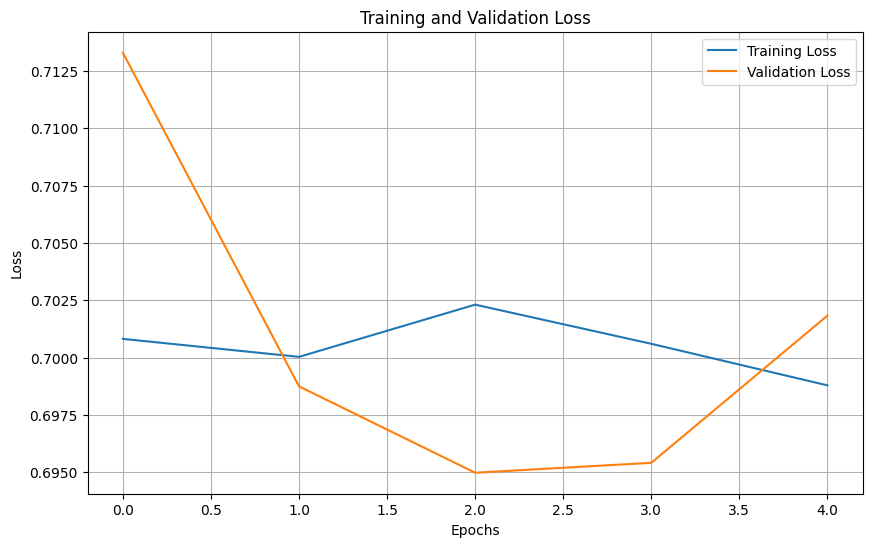

In [20]:
# plot training and validation losses

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()



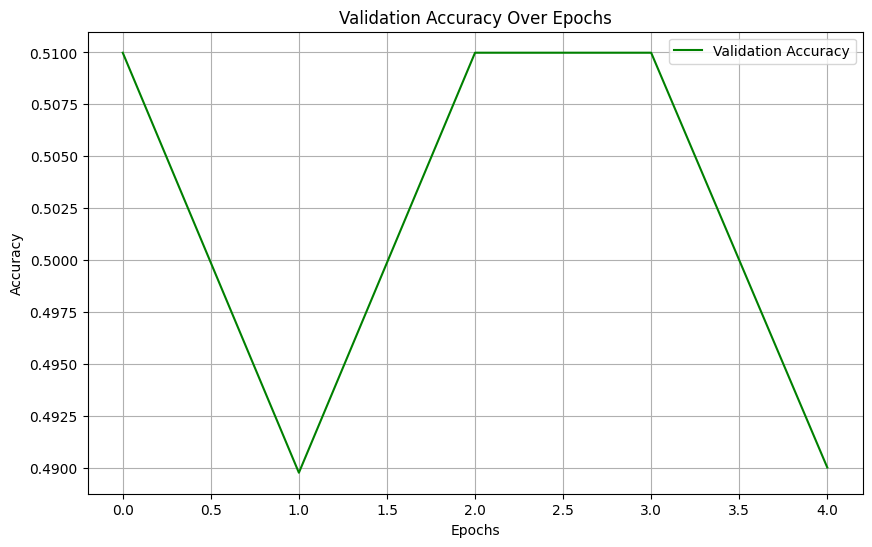

In [21]:
# plot validation accuracy

plt.figure(figsize=(10, 6))
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


#### 1.2 Incorporate stemming/lemmatization when doing text preprocessing using the NLTK library. What changes do you observe in accuracy ?

In [22]:
def create_word2idx_lemm(reviews, min_words=100, max_words=500):
    word2idx = {}
    idx = 1 
    tokenizer = RegexpTokenizer(r'\w+')

    for review in tqdm(reviews, desc="Processing reviews for word2idx"):

        tokens = clean2(review, tokenizer)
        if min_words <= len(tokens) <= max_words:
            for token in tokens:
                if token not in word2idx:
                    word2idx[token] = idx
                    idx += 1
    return word2idx



word2idx_lemm = create_word2idx_lemm(train_reviews)
print(f"Vocabulary size: {len(word2idx_lemm)}")
print(word2idx_lemm)
vocab_size_lemm = len(word2idx_lemm) + 1
train_ds_lemm = IMDBDataset_lemm(train_reviews, train_labels, word2idx_lemm, minlen=100, maxlen=500)
val_ds_lemm = IMDBDataset_lemm(val_reviews, val_labels, word2idx_lemm, minlen=100, maxlen=500)
test_ds_lemm = IMDBDataset_lemm(test_reviews, test_labels, word2idx_lemm, minlen=100, maxlen=500)
train_loader_lemm = DataLoader(train_ds_lemm, batch_size=32, shuffle=True)
val_loader_lemm = DataLoader(val_ds_lemm, batch_size=32, shuffle=False)
test_loader_lemm = DataLoader(test_ds_lemm, batch_size=32, shuffle=False)

model_lemm = RNNModel(vocab_size=vocab_size_lemm, hidden_size=hidden_size, embedding_dim=embedding_dim, num_classes=2)
model_lemm.to(device)
optimizer_lemm = optim.Adam(model_lemm.parameters(), lr=learning_rate)
loss_fn_lemm = nn.CrossEntropyLoss()
print(model_lemm)

train_losses_lemm, val_losses_lemm, val_accuracies_lemm = train_model(model_lemm, train_loader_lemm, val_loader_lemm, loss_fn_lemm, optimizer_lemm, epochs, device)
test_accuracy_lemm = test_model(model_lemm, test_loader_lemm, device)

Processing reviews for word2idx: 100%|██████████| 20000/20000 [02:12<00:00, 151.15it/s]


Vocabulary size: 39563
{'thi': 1, 'movi': 2, 'wa': 3, 'so': 4, 'poorli': 5, 'written': 6, 'and': 7, 'direct': 8, 'i': 9, 'fell': 10, 'asleep': 11, 'num': 12, 'minut': 13, 'through': 14, 'the': 15, 'joke': 16, 'in': 17, 'are': 18, 'corni': 19, 'even': 20, 'though': 21, 'plot': 22, 'is': 23, 'interest': 24, 'at': 25, 'some': 26, 'angl': 27, 'it': 28, 'too': 29, 'far': 30, 'fetch': 31, 'point': 32, 'ridicul': 33, 'if': 34, 'you': 35, 'or': 36, 'older': 37, 'will': 38, 'overlook': 39, 'write': 40, 'be': 41, 'disappoint': 42, 'but': 43, 'younger': 44, 'a': 45, 'film': 46, 'that': 47, 'captur': 48, 'your': 49, 'attent': 50, 'amaz': 51, 'with': 52, 'all': 53, 'stunt': 54, 'which': 55, 'might': 56, 'add': 57, 'done': 58, 'wish': 59, 'were': 60, 'warrior': 61, 'to': 62, 'cast': 63, 'wasn': 64, 't': 65, 'veri': 66, 'good': 67, 'music': 68, 'becaus': 69, 'like': 70, 'they': 71, 'tri': 72, 'build': 73, 'up': 74, 'tension': 75, 'didn': 76, 'fit': 77, 'on': 78, 'scale': 79, 'of': 80, 'excel': 81, 'h

Processing Reviews: 100%|██████████| 25000/25000 [02:43<00:00, 153.08it/s]


RNNModel(
  (embedding): Embedding(39564, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


Validation Epoch 1: 100%|██████████| 126/126 [00:00<00:00, 325.19it/s]


Epoch 1, Train Loss: 0.6994940338144264, Validation Loss: 0.6978423169681004, Validation Accuracy: 0.48976535197204196


Validation Epoch 2: 100%|██████████| 126/126 [00:00<00:00, 327.04it/s]


Epoch 2, Train Loss: 0.6970128137989348, Validation Loss: 0.6962594285843864, Validation Accuracy: 0.5137294058911632


Validation Epoch 3: 100%|██████████| 126/126 [00:00<00:00, 330.75it/s]


Epoch 3, Train Loss: 0.7083834960641139, Validation Loss: 0.7270921104484134, Validation Accuracy: 0.510234648027958


Validation Epoch 4: 100%|██████████| 126/126 [00:00<00:00, 325.04it/s]


Epoch 4, Train Loss: 0.7038367913063779, Validation Loss: 0.6938950689066024, Validation Accuracy: 0.5107338991512731


Validation Epoch 5: 100%|██████████| 126/126 [00:00<00:00, 330.39it/s]


Epoch 5, Train Loss: 0.700963892903461, Validation Loss: 0.6998870860016535, Validation Accuracy: 0.510234648027958


Testing: 100%|██████████| 628/628 [00:01<00:00, 337.02it/s]

Test Accuracy: 50.88%


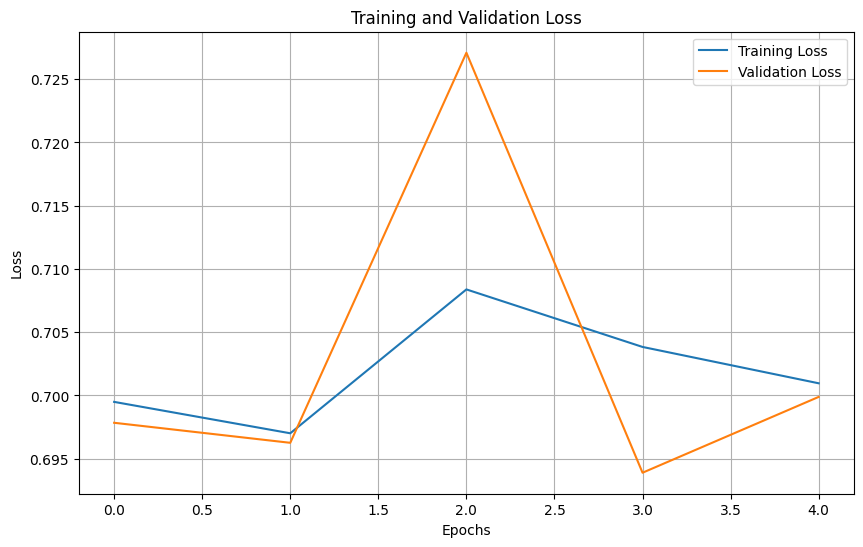

In [23]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses_lemm, label='Training Loss')
plt.plot(val_losses_lemm, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


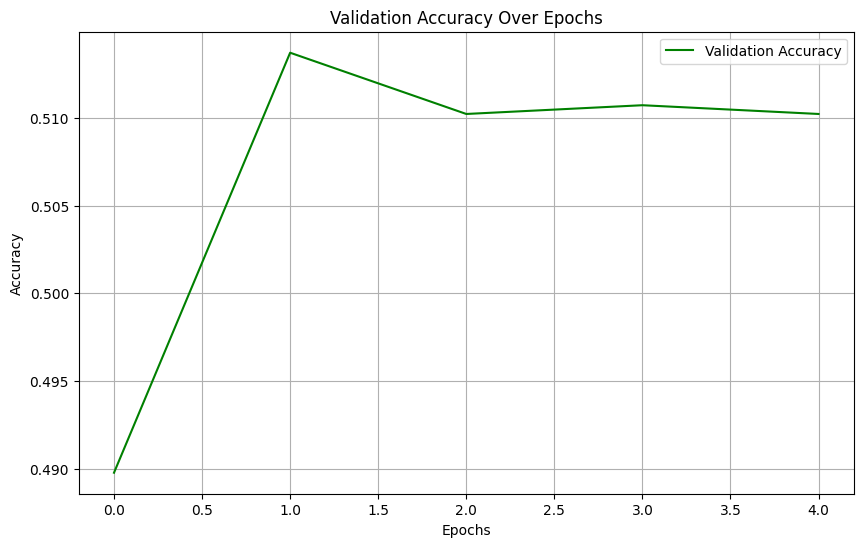

In [24]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(val_accuracies_lemm, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


# **After, incorporating stemming the accuracy increased by around 2 percent. My observation particularly is that all the words will be changed to its root form and might have helped the model by a bit to generalize better than before. **

#### 1.3 In the Model class, experiment with only picking the last output and mean of all outputs in the RNN layer. What changes do you observe ?

In [25]:
class RNNModel_last(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(RNNModel_last, self).__init__()
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_size, out_features=num_classes)

    def forward(self, X):
      embedded = self.embedding(X)  
      output, hidden = self.rnn(embedded)
      last_output = output[:, -1, :]
      logits = self.fc(last_output)
      return logits


train_ds_last = IMDBDataset_lemm(train_reviews, train_labels, word2idx_lemm, minlen=100, maxlen=500)
val_ds_last = IMDBDataset_lemm(val_reviews, val_labels, word2idx_lemm, minlen=100, maxlen=500)
test_ds_last = IMDBDataset_lemm(test_reviews, test_labels, word2idx_lemm, minlen=100, maxlen=500)
train_loader_last = DataLoader(train_ds_last, batch_size=32, shuffle=True)
val_loader_last = DataLoader(val_ds_last, batch_size=32, shuffle=False)
test_loader_last = DataLoader(test_ds_last, batch_size=32, shuffle=False)

model_last = RNNModel_last(vocab_size=vocab_size_lemm, hidden_size=hidden_size, embedding_dim=embedding_dim, num_classes=2)
model_last.to(device)
optimizer_last = optim.Adam(model_last.parameters(), lr=learning_rate)
loss_fn_last = nn.CrossEntropyLoss()
print(model_last)
train_losses_last, val_losses_last, val_accuracies_last = train_model(model_last, train_loader_last, val_loader_last, loss_fn_last, optimizer_last, epochs, device)
test_accuracy_last = test_model(model_last, test_loader_last, device)

Processing Reviews: 100%|██████████| 25000/25000 [02:42<00:00, 154.13it/s]


RNNModel_last(
  (embedding): Embedding(39564, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


Validation Epoch 1: 100%|██████████| 126/126 [00:00<00:00, 329.18it/s]


Epoch 1, Train Loss: 0.7040533912609298, Validation Loss: 0.7112500038411882, Validation Accuracy: 0.49001497753369944


Validation Epoch 2: 100%|██████████| 126/126 [00:00<00:00, 325.63it/s]


Epoch 2, Train Loss: 0.6959446036958125, Validation Loss: 0.7142761226684328, Validation Accuracy: 0.510234648027958


Validation Epoch 3: 100%|██████████| 126/126 [00:00<00:00, 330.32it/s]


Epoch 3, Train Loss: 0.7047931512750952, Validation Loss: 0.7162071608361744, Validation Accuracy: 0.49001497753369944


Validation Epoch 4: 100%|██████████| 126/126 [00:00<00:00, 321.76it/s]


Epoch 4, Train Loss: 0.7051686058006439, Validation Loss: 0.6935067247776758, Validation Accuracy: 0.49026460309535697


Validation Epoch 5: 100%|██████████| 126/126 [00:00<00:00, 322.81it/s]


Epoch 5, Train Loss: 0.7033174167353794, Validation Loss: 0.6953320711378067, Validation Accuracy: 0.48951572641038443


Testing: 100%|██████████| 628/628 [00:01<00:00, 335.21it/s]

Test Accuracy: 49.02%


# ****The accuracy when we take from either hidden state or last output is relatively Same because, i think the last output also has same problem which RNN was facing before. It is finding it difficult to keep the whole context and hence prediction is going wrong. and moreover, since it is just 2 class classification it is giving atleast 50 percent accuracy, else it would be even less.

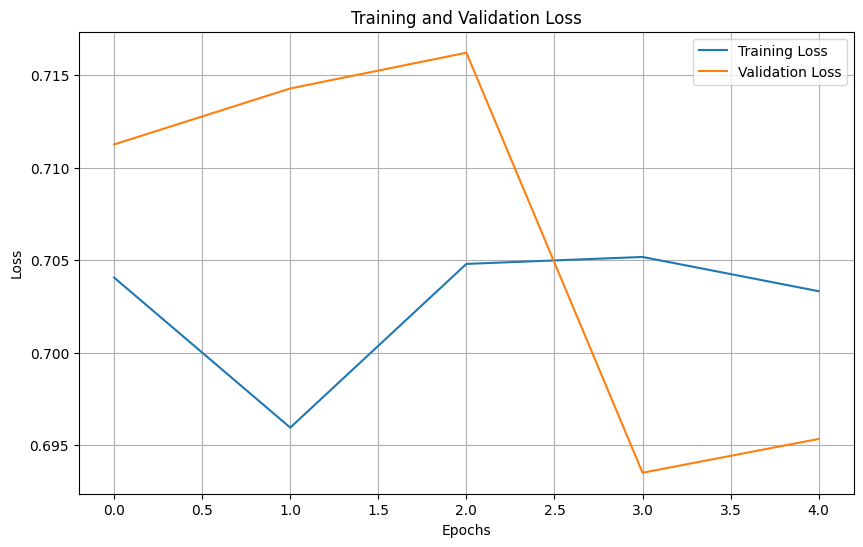

In [27]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses_last, label='Training Loss')
plt.plot(val_losses_last, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

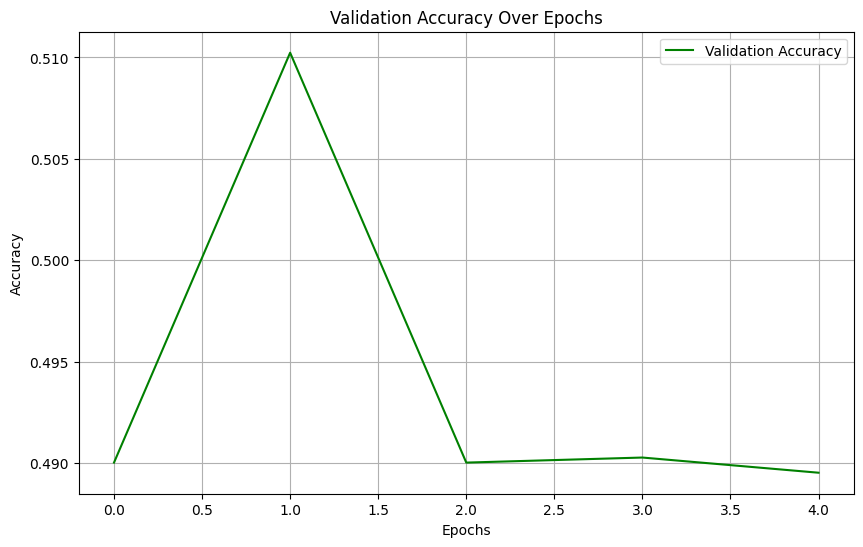

In [28]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(val_accuracies_last, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
class RNNModel_mean(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(RNNModel_mean, self).__init__()
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_size, out_features=num_classes)

    def forward(self, X):
        embedded = self.embedding(X) 
        output, hidden = self.rnn(embedded) 
        mean_output = output.mean(dim=1)
        logits = self.fc(mean_output)
        return logits


train_ds_mean = IMDBDataset_lemm(train_reviews, train_labels, word2idx_lemm, minlen=100, maxlen=500)
val_ds_mean = IMDBDataset_lemm(val_reviews, val_labels, word2idx_lemm, minlen=100, maxlen=500)
test_ds_mean = IMDBDataset_lemm(test_reviews, test_labels, word2idx_lemm, minlen=100, maxlen=500)
train_loader_mean = DataLoader(train_ds_mean, batch_size=32, shuffle=True)
val_loader_mean = DataLoader(val_ds_mean, batch_size=32, shuffle=False)
test_loader_mean = DataLoader(test_ds_mean, batch_size=32, shuffle=False)    
model_mean = RNNModel_mean(vocab_size=vocab_size_lemm, hidden_size=hidden_size, embedding_dim=embedding_dim, num_classes=2)
model_mean.to(device)
optimizer_mean = optim.Adam(model_mean.parameters(), lr=learning_rate)
loss_fn_mean = nn.CrossEntropyLoss()
print(model_mean)
train_losses_mean, val_losses_mean, val_accuracies_mean = train_model(model_mean, train_loader_mean, val_loader_mean, loss_fn_mean, optimizer_mean, epochs, device)
test_accuracy_mean = test_model(model_mean, test_loader_mean, device)

Processing Reviews: 100%|██████████| 25000/25000 [02:42<00:00, 153.45it/s]


RNNModel_mean(
  (embedding): Embedding(39564, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


Validation Epoch 1: 100%|██████████| 126/126 [00:00<00:00, 320.61it/s]


Epoch 1, Train Loss: 0.6406158800737791, Validation Loss: 0.5334342557286459, Validation Accuracy: 0.7481278082875686


Validation Epoch 2: 100%|██████████| 126/126 [00:00<00:00, 312.41it/s]


Epoch 2, Train Loss: 0.6464498816614607, Validation Loss: 0.6683281669541011, Validation Accuracy: 0.5846230654018971


Validation Epoch 3: 100%|██████████| 126/126 [00:00<00:00, 318.53it/s]


Epoch 3, Train Loss: 0.5656612123626162, Validation Loss: 0.47365258752353606, Validation Accuracy: 0.810034947578632


Validation Epoch 4: 100%|██████████| 126/126 [00:00<00:00, 318.66it/s]


Epoch 4, Train Loss: 0.374692944119651, Validation Loss: 0.3975858535794985, Validation Accuracy: 0.829006490264603


Validation Epoch 5: 100%|██████████| 126/126 [00:00<00:00, 313.90it/s]


Epoch 5, Train Loss: 0.2912490042557279, Validation Loss: 0.38260460029991844, Validation Accuracy: 0.8312531203195207


Testing: 100%|██████████| 628/628 [00:01<00:00, 328.66it/s]

Test Accuracy: 82.72%


# ****This is model is able to give a better accuracy of 82 percent because it is able to preserve the context 
# as we are passing the mean forward. So because of this, it is able to distribute contextual information
# and able to mitigate vanishing gradient also.hence giving a better result

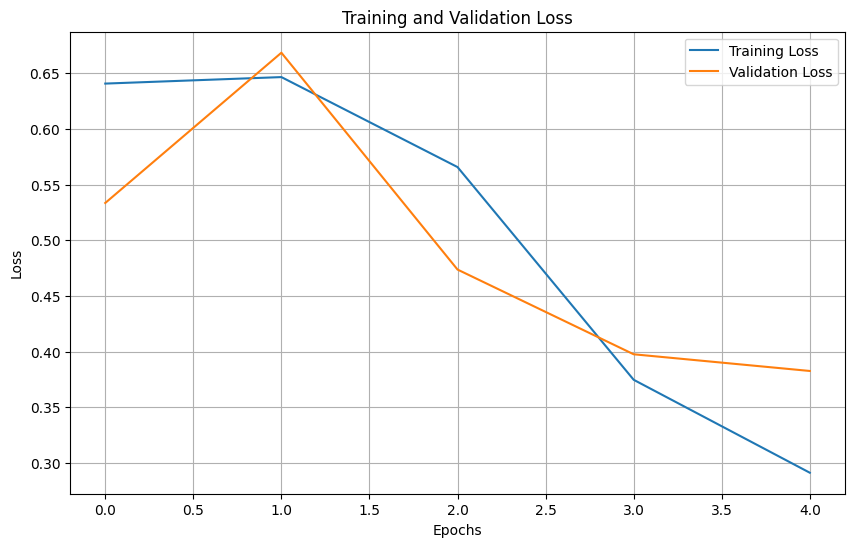

In [31]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses_mean, label='Training Loss')
plt.plot(val_losses_mean, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

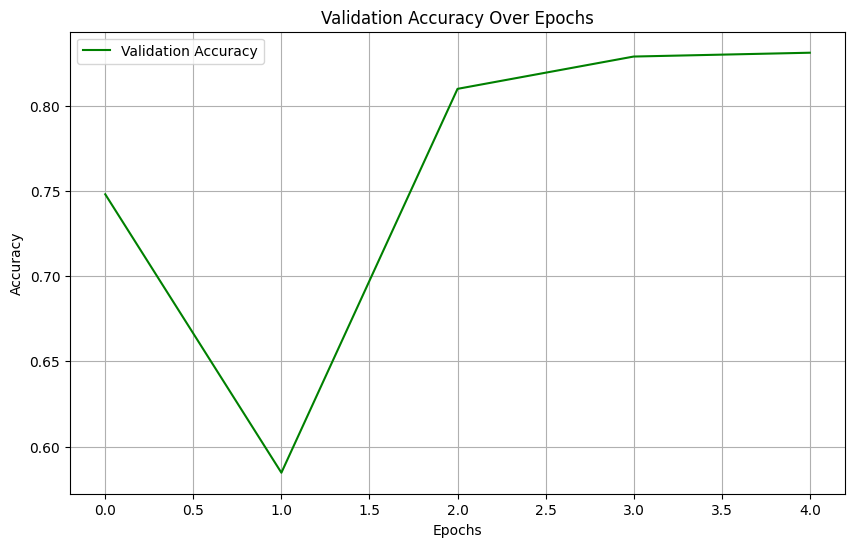

In [32]:

plt.figure(figsize=(10, 6))
plt.plot(val_accuracies_mean, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### 2. Hyperparameter Tuning
#### 2.1 Starting with the best configurations based on the above experiments, experiment with 5 different hyperparameter configurations. You can change the size of embedding layer, hidden state, batch in the dataloader.


In [33]:
configurations = [
    {"embedding_dim": 128, "hidden_size": 256, "batch_size": 32},
    {"embedding_dim": 256, "hidden_size": 256, "batch_size": 32},
    {"embedding_dim": 128, "hidden_size": 512, "batch_size": 32},
    {"embedding_dim": 128, "hidden_size": 256, "batch_size": 16},
    {"embedding_dim": 256, "hidden_size": 512, "batch_size": 32},
]

best_config_accuracy = 0
best_config = None
best_model_state = None
results = []

for config in configurations:
    model_hyper = RNNModel_mean(vocab_size=vocab_size_lemm,hidden_size=config["hidden_size"],
                     embedding_dim=config["embedding_dim"], num_classes=2).to(device)
    optimizer_hyper = optim.Adam(model_hyper.parameters())
    loss_fn_hyper = nn.CrossEntropyLoss()
    train_dataset_hyper = IMDBDataset_lemm(train_reviews, train_labels, word2idx_lemm, minlen=100, maxlen=500)
    val_dataset_hyper = IMDBDataset_lemm(val_reviews, val_labels, word2idx_lemm,minlen=100, maxlen=500)
    train_loader_hyper = DataLoader(train_dataset_hyper, batch_size=config["batch_size"], shuffle=True)
    val_loader_hyper = DataLoader(val_dataset_hyper, batch_size=config["batch_size"])
    train_losses_hyper, val_losses_hyper, val_accuracies_hyper = train_model(model_hyper,train_loader_hyper,val_loader_hyper,loss_fn_hyper,optimizer_hyper,epochs,device)
    print(len(val_accuracies))
    current_config_accuracy = val_accuracies[-1]

    if current_config_accuracy > best_config_accuracy:
       best_config = config
       best_model =  RNNModel_mean(vocab_size=vocab_size_lemm, hidden_size=best_config["hidden_size"],
                            embedding_dim=best_config["embedding_dim"], num_classes=2).to(device)

############## training the best model###############################################

train_ds_best = IMDBDataset_lemm(train_reviews, train_labels, word2idx_lemm, minlen=100, maxlen=500)
val_ds_best = IMDBDataset_lemm(val_reviews, val_labels, word2idx_lemm, minlen=100, maxlen=500)
test_ds_best = IMDBDataset_lemm(test_reviews, test_labels, word2idx_lemm, minlen=100, maxlen=500)
train_loader_best = DataLoader(train_ds_best, batch_size=best_config["batch_size"], shuffle=True)
val_loader_best = DataLoader(val_ds_best, batch_size=best_config["batch_size"], shuffle=False)
test_loader_best = DataLoader(test_ds_best, batch_size=best_config["batch_size"], shuffle=False)    
#model_mean = RNNModel_mean(vocab_size=vocab_size_lemm, hidden_size=hidden_size, embedding_dim=embedding_dim, num_classes=2)
best_model.to(device)
optimizer_best = optim.Adam(best_model.parameters(), lr=learning_rate)
loss_fn_best = nn.CrossEntropyLoss()
print(best_model)
train_losses_best, val_losses_best, val_accuracies_best = train_model(best_model, train_loader_best, val_loader_best, loss_fn_best, optimizer_best, epochs, device)
        

test_accuracy = test_model(best_model, test_loader_best, device)
print("TEST ACCURACY")
print(test_accuracy)

Validation Epoch 1: 100%|██████████| 126/126 [00:00<00:00, 320.77it/s]


Epoch 1, Train Loss: 0.6855801575449834, Validation Loss: 0.7160427409505087, Validation Accuracy: 0.527209186220669


Validation Epoch 2: 100%|██████████| 126/126 [00:00<00:00, 317.14it/s]


Epoch 2, Train Loss: 0.6898049019366147, Validation Loss: 0.6999503028771233, Validation Accuracy: 0.5134797803295057


Validation Epoch 3: 100%|██████████| 126/126 [00:00<00:00, 318.38it/s]


Epoch 3, Train Loss: 0.6099109042331992, Validation Loss: 0.6351119525848873, Validation Accuracy: 0.7234148776834748


Validation Epoch 4: 100%|██████████| 126/126 [00:00<00:00, 310.83it/s]


Epoch 4, Train Loss: 0.6013068474265209, Validation Loss: 0.6418570649056208, Validation Accuracy: 0.5624063904143785


Validation Epoch 5: 100%|██████████| 126/126 [00:00<00:00, 315.61it/s]


Epoch 5, Train Loss: 0.5210462561641557, Validation Loss: 0.417175077729755, Validation Accuracy: 0.8247628557164254
5


Validation Epoch 1: 100%|██████████| 126/126 [00:00<00:00, 292.28it/s]


Epoch 1, Train Loss: 0.5884076625227453, Validation Loss: 0.5701069529094394, Validation Accuracy: 0.8042935596605092


Validation Epoch 2: 100%|██████████| 126/126 [00:00<00:00, 292.72it/s]


Epoch 2, Train Loss: 0.39608402763942324, Validation Loss: 0.3464529138235819, Validation Accuracy: 0.8579630554168747


Validation Epoch 3: 100%|██████████| 126/126 [00:00<00:00, 294.48it/s]


Epoch 3, Train Loss: 0.26451184418037593, Validation Loss: 0.34259236769543755, Validation Accuracy: 0.8602096854717923


Validation Epoch 4: 100%|██████████| 126/126 [00:00<00:00, 295.49it/s]


Epoch 4, Train Loss: 0.20953910564818232, Validation Loss: 0.35232075593537754, Validation Accuracy: 0.8662006989515726


Validation Epoch 5: 100%|██████████| 126/126 [00:00<00:00, 292.56it/s]


Epoch 5, Train Loss: 0.14484627286261653, Validation Loss: 0.32356539581503185, Validation Accuracy: 0.8716924613080379
5


Validation Epoch 1: 100%|██████████| 126/126 [00:01<00:00, 99.50it/s]


Epoch 1, Train Loss: 0.7020461923810115, Validation Loss: 0.730102433098687, Validation Accuracy: 0.5107338991512731


Validation Epoch 2: 100%|██████████| 126/126 [00:01<00:00, 99.65it/s]


Epoch 2, Train Loss: 0.6961280892332237, Validation Loss: 0.7039310818626767, Validation Accuracy: 0.48652021967049425


Validation Epoch 3: 100%|██████████| 126/126 [00:01<00:00, 99.93it/s]


Epoch 3, Train Loss: 0.6651634695639174, Validation Loss: 0.6755504707495371, Validation Accuracy: 0.544682975536695


Validation Epoch 4: 100%|██████████| 126/126 [00:01<00:00, 100.48it/s]


Epoch 4, Train Loss: 0.6148735174976022, Validation Loss: 0.5374269161432509, Validation Accuracy: 0.7753369945082377


Validation Epoch 5: 100%|██████████| 126/126 [00:01<00:00, 100.21it/s]


Epoch 5, Train Loss: 0.4473304102620281, Validation Loss: 0.45141789092430995, Validation Accuracy: 0.8040439340988518
5


Validation Epoch 1: 100%|██████████| 251/251 [00:00<00:00, 342.71it/s]


Epoch 1, Train Loss: 0.6998181816828678, Validation Loss: 0.6674511050323091, Validation Accuracy: 0.535946080878682


Validation Epoch 2: 100%|██████████| 251/251 [00:00<00:00, 352.19it/s]


Epoch 2, Train Loss: 0.5001493286326587, Validation Loss: 0.5178304219329025, Validation Accuracy: 0.808537194208687


Validation Epoch 3: 100%|██████████| 251/251 [00:00<00:00, 351.72it/s]


Epoch 3, Train Loss: 0.33966872190678143, Validation Loss: 0.33822641545439147, Validation Accuracy: 0.853220169745382


Validation Epoch 4: 100%|██████████| 251/251 [00:00<00:00, 351.74it/s]


Epoch 4, Train Loss: 0.28817945932487093, Validation Loss: 0.327467998022221, Validation Accuracy: 0.8629555666500249


Validation Epoch 5: 100%|██████████| 251/251 [00:00<00:00, 338.98it/s]


Epoch 5, Train Loss: 0.21753743555641686, Validation Loss: 0.3127687901288152, Validation Accuracy: 0.872191712431353
5


Validation Epoch 1: 100%|██████████| 126/126 [00:01<00:00, 93.92it/s]


Epoch 1, Train Loss: 0.7104816186238095, Validation Loss: 0.6898655758963691, Validation Accuracy: 0.5169745381927109


Validation Epoch 2: 100%|██████████| 126/126 [00:01<00:00, 93.20it/s]


Epoch 2, Train Loss: 0.6257377835027725, Validation Loss: 0.4729750887269065, Validation Accuracy: 0.7933100349475787


Validation Epoch 3: 100%|██████████| 126/126 [00:01<00:00, 94.25it/s]


Epoch 3, Train Loss: 0.4153858045954628, Validation Loss: 0.3870425292896846, Validation Accuracy: 0.8409885172241638


Validation Epoch 4: 100%|██████████| 126/126 [00:01<00:00, 94.75it/s]


Epoch 4, Train Loss: 0.33061242035304406, Validation Loss: 0.40082636570173596, Validation Accuracy: 0.8267598602096855


Validation Epoch 5: 100%|██████████| 126/126 [00:01<00:00, 94.67it/s]


Epoch 5, Train Loss: 0.2654359665554596, Validation Loss: 0.3411275300951231, Validation Accuracy: 0.8579630554168747
5


Testing: 100%|██████████| 628/628 [00:06<00:00, 94.65it/s]

Test Accuracy: 50.97%
TEST ACCURACY
0.509662316963841


In [34]:
########################3train the best model and test##############################
train_ds_best = IMDBDataset_lemm(train_reviews, train_labels, word2idx_lemm, minlen=100, maxlen=500)
val_ds_best = IMDBDataset_lemm(val_reviews, val_labels, word2idx_lemm, minlen=100, maxlen=500)
test_ds_best = IMDBDataset_lemm(test_reviews, test_labels, word2idx_lemm, minlen=100, maxlen=500)
train_loader_best = DataLoader(train_ds_best, batch_size=best_config["batch_size"], shuffle=True)
val_loader_best = DataLoader(val_ds_best, batch_size=best_config["batch_size"], shuffle=False)
test_loader_best = DataLoader(test_ds_best, batch_size=best_config["batch_size"], shuffle=False)    
#model_mean = RNNModel_mean(vocab_size=vocab_size_lemm, hidden_size=hidden_size, embedding_dim=embedding_dim, num_classes=2)
best_model.to(device)
optimizer_best = optim.Adam(best_model.parameters(), lr=learning_rate)
loss_fn_best = nn.CrossEntropyLoss()
print(best_model)
train_losses_best, val_losses_best, val_accuracies_best = train_model(best_model, train_loader_best, val_loader_best, loss_fn_best, optimizer_best, epochs, device)
        

test_accuracy = test_model(best_model, test_loader_best, device)
print("TEST ACCURACY")
print(test_accuracy)

Processing Reviews: 100%|██████████| 25000/25000 [02:42<00:00, 153.94it/s]


RNNModel_mean(
  (embedding): Embedding(39564, 256)
  (rnn): RNN(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=2, bias=True)
)


Validation Epoch 1: 100%|██████████| 126/126 [00:01<00:00, 94.65it/s]


Epoch 1, Train Loss: 0.6697354726938612, Validation Loss: 0.6776439074486021, Validation Accuracy: 0.5229655516724913


Validation Epoch 2: 100%|██████████| 126/126 [00:01<00:00, 93.67it/s]


Epoch 2, Train Loss: 0.5549368507477391, Validation Loss: 0.6366676210411011, Validation Accuracy: 0.6243135297054418


Validation Epoch 3: 100%|██████████| 126/126 [00:01<00:00, 94.17it/s]


Epoch 3, Train Loss: 0.4943831487005925, Validation Loss: 0.40220311449633706, Validation Accuracy: 0.835746380429356


Validation Epoch 4: 100%|██████████| 126/126 [00:01<00:00, 94.74it/s]


Epoch 4, Train Loss: 0.29211969050278225, Validation Loss: 0.34468029794238864, Validation Accuracy: 0.8529705441837244


Validation Epoch 5: 100%|██████████| 126/126 [00:01<00:00, 95.17it/s]


Epoch 5, Train Loss: 0.252784870535254, Validation Loss: 0.3370310544139809, Validation Accuracy: 0.8529705441837244


Testing: 100%|██████████| 628/628 [00:06<00:00, 95.55it/s]

Test Accuracy: 84.36%
TEST ACCURACY
0.8435601155493575


### 3. After RNNs
#### 3.1 Keeping all the parameters same, replace the RNN layer with the LSTM layer using nn.LSTM. What changes do you observe ? Explain why LSTM layer would affect performance.

In [92]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim, num_classes):
        super(LSTMModel, self).__init__()
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_size, out_features=num_classes)

    def forward(self, X):
        embedded = self.embedding(X) 
        output, (hidden, cell) = self.lstm(embedded) 
        mean_output = output.mean(dim=1)
        logits = self.fc(mean_output)
        return logits


train_dataset_lstm = IMDBDataset_lemm(train_reviews, train_labels, word2idx_lemm, minlen=100, maxlen=500)
val_dataset_lstm = IMDBDataset_lemm(val_reviews, val_labels, word2idx_lemm, minlen=100, maxlen=500)
test_dataset_lstm = IMDBDataset_lemm(test_reviews, test_labels, word2idx_lemm, minlen=100, maxlen=500)  

train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=best_config["batch_size"], shuffle=True)
val_loader_lstm = DataLoader(val_dataset_lstm, batch_size=best_config["batch_size"])
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=best_config["batch_size"])

model_lstm = LSTMModel(vocab_size=vocab_size_lemm, hidden_size=best_config["hidden_size"],
                       embedding_dim=best_config["embedding_dim"], num_classes=2).to(device)
model_lstm.to(device)
optimizer_lstm = optim.Adam(model_lstm.parameters(),lr=learning_rate)
loss_fn_lstm = nn.CrossEntropyLoss()


train_losses_lstm, val_losses_lstm, val_accuracies_lstm = train_model(model_lstm, train_loader_lstm, val_loader_lstm, loss_fn_lstm, optimizer_lstm, epochs, device)

test_accuracy_lstm = test_model(model_lstm, test_loader_lstm, device)
print("LSTM Test Accuracy:", test_accuracy_lstm)



Processing Reviews: 100%|██████████| 20000/20000 [02:17<00:00, 145.75it/s]

Processing Reviews: 100%|██████████| 5000/5000 [00:34<00:00, 145.65it/s]

Processing Reviews: 100%|██████████| 25000/25000 [02:46<00:00, 149.83it/s]

Training Epoch 1: 100%|██████████| 502/502 [00:37<00:00, 13.41it/s]

Validation Epoch 1: 100%|██████████| 126/126 [00:03<00:00, 34.64it/s]


Epoch 1, Train Loss: 0.5122541642462115, Validation Loss: 0.34946128714179236, Validation Accuracy: 0.8462306540189716

Saved Best Model


Training Epoch 2: 100%|██████████| 502/502 [00:39<00:00, 12.56it/s]

Validation Epoch 2: 100%|██████████| 126/126 [00:03<00:00, 33.84it/s]


Epoch 2, Train Loss: 0.2626211114109037, Validation Loss: 0.26859265388477416, Validation Accuracy: 0.8856714927608587

Saved Best Model


Training Epoch 3: 100%|██████████| 502/502 [00:39<00:00, 12.82it/s]

Validation Epoch 3: 100%|██████████| 126/126 [00:03<00:00, 34.15it/s]


Epoch 3, Train Loss: 0.14657312001201855, Validation Loss: 0.3044977021950578, Validation Accuracy: 0.882426360459311


Training Epoch 4: 100%|██████████| 502/502 [00:39<00:00, 12.70it/s]

Validation Epoch 4: 100%|██████████| 126/126 [00:03<00:00, 33.94it/s]


Epoch 4, Train Loss: 0.06630017798008078, Validation Loss: 0.3417218941899519, Validation Accuracy: 0.891163255117324

Saved Best Model


Training Epoch 5: 100%|██████████| 502/502 [00:39<00:00, 12.76it/s]

Validation Epoch 5: 100%|██████████| 126/126 [00:03<00:00, 34.01it/s]


Epoch 5, Train Loss: 0.024725094770061167, Validation Loss: 0.28478401378979756, Validation Accuracy: 0.8826759860209685


Testing: 100%|██████████| 628/628 [00:18<00:00, 34.02it/s]

Test Accuracy: 86.61%

LSTM Test Accuracy: 0.8661221237175017


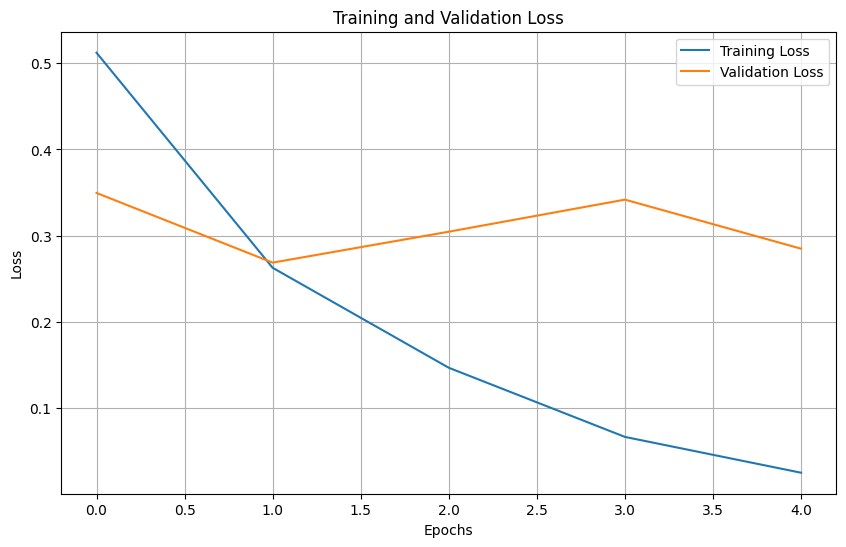

In [93]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses_lstm, label='Training Loss')
plt.plot(val_losses_lstm, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

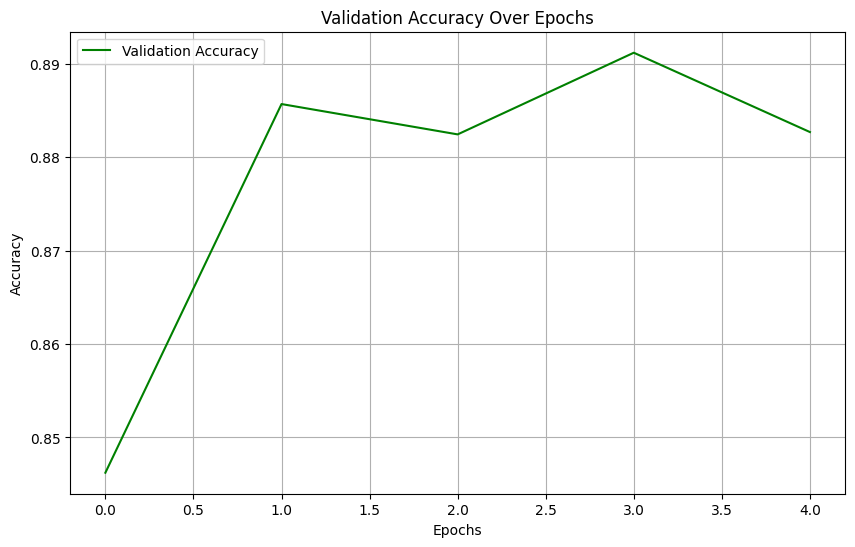

In [94]:
plt.figure(figsize=(10, 6))
plt.plot(val_accuracies_lstm, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# ****Lstm as the name suggests captures the long term dependencies. 
# LSTMs are explicitly designed to address the vanishing gradient problem, enabling them to capture long-range dependencies within the sequence more effectively than simple RNNs, thereby improving accuracy on tasks requiring understanding of extended contexts.